In [1]:
#!/usr/bin/python3
# coding: utf-8
# prefectures

In [2]:
import codecs
from datetime import datetime as dt
from datetime import timedelta as td
import matplotlib
import numpy as np
import os
import pandas as pd
from PIL import Image
import sys
if "ipy" not in sys.argv[0]:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly
import plotly.express as px
import plotly.tools as tls
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as offline
from plotly.subplots import make_subplots
if "ipy" in sys.argv[0]:
    offline.init_notebook_mode()
from sklearn.neighbors import LocalOutlierFactor
from cov19utils import create_basic_plot_figure, \
    show_and_clear, moving_average, \
    blank2zero, csv2array, \
    get_twitter, tweet_with_image, \
    get_gpr_predict, FONT_NAME, DT_OFFSET, \
    download_if_needed, json2nparr, code2int, age2int, \
    get_populations, get_os_idx_of_arr, dump_val_in_arr, \
    calc_last1w2w_dif, create_basic_scatter_figure, \
    show_and_save_plotly

In [3]:
populations = get_populations()
#print(populations)

All population in Japan: 127094745


In [4]:
# 全国情報
ogiwara_uri = "https://raw.githubusercontent.com/kaz-ogiwara/covid19/master/data/"
pref_file = "prefectures.csv"
download_if_needed(ogiwara_uri, pref_file)

In [5]:
offsets = dict(
    year  = 0, # 年
    month = 1, # 月
    day   = 2, # 日
    st_ja = 3, # 都道府県
    st_en = 4, # state
    posis = 5, # 陽性者数
    tests = 6, # 検査数
    hospi = 7, # hospitalized
    serio = 8, # serious
    disch = 9, # discharged
    death =10, # deaths
    ern   =11, # Effective Reproduction Number
)

In [6]:
dt_start = dt.strptime("2020/2/8", "%Y/%m/%d") # 統計開始日
dt_now   = dt.now() # 現在日時
dt_delta = (dt_now - dt_start).days # 差分
n_states = 47 # 都道府県数
erns = [] # 実効再生産数
poss = [] # 陽性者数
test = [] # 検査数
for i in np.arange(dt_delta):
    erns.append(np.zeros(n_states+1).tolist())
    poss.append(np.zeros(n_states+1).tolist())
    test.append(np.zeros(n_states+1).tolist())
    test[i][0] = poss[i][0] = erns[i][0] = i

In [7]:
with codecs.open("prefectures.csv", encoding='utf-8') as f:
    l = f.readline()
    cnt = 0
    while l:
        l = f.readline().replace("\r\n", "").rstrip()
        elems = l.split(',')
        if len(elems) < 2:
            continue
        dt_idx  = (dt(int(elems[0]), int(elems[1]), int(elems[2])) - dt_start).days
        st_name = elems[offsets['st_en']]
        st_idx  = populations[st_name]['code']
        erns[dt_idx][st_idx] = blank2zero(elems[offsets['ern']])
        poss[dt_idx][st_idx] = blank2zero(elems[offsets['posis']])
        tested = blank2zero(elems[offsets['tests']])
        if tested > 0:
            test[dt_idx][st_idx] = tested
        cnt += 1
print("Load {} lines.".format(cnt))

Load 10195 lines.


In [8]:
erns = np.array(erns)
poss = np.array(poss)
test = np.array(test)

In [9]:
os_idx = get_os_idx_of_arr(erns, dt_delta)
latest_erns = erns[os_idx] # 最新の実効再生産数
dump_val_in_arr(populations, latest_erns, "最新の実効再生産数")

Data offset index: -1
最新の実効再生産数: 北海道=1.4 青森=0.0 岩手=0.0 宮城=1.4 秋田=0.3 山形=0.0 福島=1.8 茨城=0.9 栃木=0.8 群馬=1.0 埼玉=1.2 千葉=1.1 東京=1.0 神奈川=1.0 新潟=0.0 山梨=0.4 長野=0.9 岐阜=0.4 静岡=0.7 愛知=0.7 三重=0.4 富山=0.0 石川=2.2 福井=0.0 滋賀=0.9 京都=0.8 大阪=1.0 兵庫=0.9 奈良=1.0 和歌山=2.4 鳥取=0.0 島根=0.0 岡山=1.0 広島=0.4 山口=2.0 徳島=0.0 香川=0.0 愛媛=0.0 高知=0.0 福岡=1.4 佐賀=1.6 長崎=0.6 熊本=1.8 大分=0.0 宮崎=0.0 鹿児島=0.8 沖縄=1.0 


In [10]:
os_idx = get_os_idx_of_arr(poss, dt_delta)
latest_poss = poss[os_idx] # 最新の感染者数
dump_val_in_arr(populations, latest_poss, "最新の感染者数", 0)

Data offset index: -1
最新の感染者数: 北海道=2347 青森=37 岩手=24 宮城=484 秋田=59 山形=81 福島=314 茨城=709 栃木=445 群馬=759 埼玉=5082 千葉=4311 東京=27715 神奈川=7508 新潟=179 山梨=196 長野=320 岐阜=634 静岡=565 愛知=5525 三重=537 富山=422 石川=780 福井=249 滋賀=514 京都=1809 大阪=11154 兵庫=2893 奈良=599 和歌山=249 鳥取=36 島根=140 岡山=163 広島=627 山口=209 徳島=149 香川=94 愛媛=115 高知=139 福岡=5101 佐賀=248 長崎=239 熊本=690 大分=158 宮崎=344 鹿児島=447 沖縄=2740 


In [11]:
diff1w_poss, diff2w_poss = calc_last1w2w_dif(poss, dt_delta)
dump_val_in_arr(populations, diff1w_poss, "1週間陽性者数", 0)
dump_val_in_arr(populations, diff2w_poss, "2週間陽性者数", 0)

Data offset index: -1
1週間陽性者数: 北海道=188 青森=0 岩手=1 宮城=59 秋田=1 山形=3 福島=47 茨城=33 栃木=8 群馬=31 埼玉=282 千葉=264 東京=1231 神奈川=372 新潟=9 山梨=3 長野=7 岐阜=4 静岡=14 愛知=106 三重=10 富山=0 石川=3 福井=5 滋賀=9 京都=42 大阪=345 兵庫=110 奈良=18 和歌山=7 鳥取=0 島根=0 岡山=5 広島=24 山口=8 徳島=0 香川=1 愛媛=0 高知=1 福岡=47 佐賀=2 長崎=1 熊本=83 大分=0 宮崎=0 鹿児島=19 沖縄=152 
2週間陽性者数: 北海道=308 青森=2 岩手=1 宮城=95 秋田=6 山形=3 福島=67 茨城=71 栃木=18 群馬=60 埼玉=500 千葉=506 東京=2461 神奈川=764 新潟=9 山梨=16 長野=15 岐阜=18 静岡=39 愛知=284 三重=43 富山=10 石川=4 福井=5 滋賀=19 京都=99 大阪=707 兵庫=235 奈良=37 和歌山=9 鳥取=0 島根=0 岡山=10 広島=111 山口=11 徳島=2 香川=1 愛媛=1 高知=1 福岡=78 佐賀=3 長崎=3 熊本=118 大分=0 宮崎=0 鹿児島=47 沖縄=313 


In [12]:
# 都道府県別 罹患率
incid1w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (1週足)
incid2w_rate = np.zeros(n_states + 1).tolist() # 罹患率 (2週足)
incid_all_rate = np.zeros(n_states + 1).tolist() # 罹患率 (全期間)
for k, v in populations.items():
    i = v['code']
    incid1w_rate[i] = (diff1w_poss[i] / v['total']) * 100 # percentage
    incid2w_rate[i] = (diff2w_poss[i] / v['total']) * 100 # percentage
    incid_all_rate[i] = (latest_poss[i] / v['total']) * 100 # percentage
dump_val_in_arr(populations, incid_all_rate, "全期間罹患率", 3)

全期間罹患率: 北海道=0.044 青森=0.003 岩手=0.002 宮城=0.021 秋田=0.006 山形=0.007 福島=0.016 茨城=0.024 栃木=0.023 群馬=0.038 埼玉=0.070 千葉=0.069 東京=0.205 神奈川=0.082 新潟=0.008 山梨=0.023 長野=0.015 岐阜=0.031 静岡=0.015 愛知=0.074 三重=0.030 富山=0.040 石川=0.068 福井=0.032 滋賀=0.036 京都=0.069 大阪=0.126 兵庫=0.052 奈良=0.044 和歌山=0.026 鳥取=0.006 島根=0.020 岡山=0.008 広島=0.022 山口=0.015 徳島=0.020 香川=0.010 愛媛=0.008 高知=0.019 福岡=0.100 佐賀=0.030 長崎=0.017 熊本=0.039 大分=0.014 宮崎=0.031 鹿児島=0.027 沖縄=0.191 


In [13]:
diff1w_test, diff2w_test = calc_last1w2w_dif(test, dt_delta)
dump_val_in_arr(populations, diff1w_test, "1週間陽検査数", 0)
dump_val_in_arr(populations, diff2w_test, "2週間陽検査数", 0)

Data offset index: -1
1週間陽検査数: 北海道=4750 青森=132 岩手=317 宮城=633 秋田=164 山形=88 福島=1798 茨城=255 栃木=1930 群馬=1921 埼玉=7070 千葉=8282 東京=22409 神奈川=11076 新潟=590 山梨=214 長野=853 岐阜=879 静岡=2367 愛知=5208 三重=820 富山=741 石川=854 福井=322 滋賀=689 京都=2152 大阪=10870 兵庫=2772 奈良=1078 和歌山=311 鳥取=35 島根=110 岡山=544 広島=977 山口=549 徳島=105 香川=595 愛媛=56 高知=32 福岡=7776 佐賀=126 長崎=975 熊本=930 大分=823 宮崎=55 鹿児島=993 沖縄=3662 
2週間陽検査数: 北海道=8337 青森=242 岩手=542 宮城=1333 秋田=215 山形=181 福島=3222 茨城=627 栃木=3908 群馬=4546 埼玉=13625 千葉=18830 東京=54868 神奈川=21629 新潟=1154 山梨=484 長野=1564 岐阜=1984 静岡=4635 愛知=10307 三重=1803 富山=1599 石川=1841 福井=508 滋賀=1262 京都=4770 大阪=21928 兵庫=5811 奈良=2093 和歌山=443 鳥取=108 島根=333 岡山=544 広島=1900 山口=1175 徳島=223 香川=1066 愛媛=138 高知=90 福岡=96388 佐賀=454 長崎=1888 熊本=1367 大分=1703 宮崎=122 鹿児島=2005 沖縄=6215 


In [14]:
# 都道府県別 陽性率
test1w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (1週足)
test2w_rate = np.zeros(n_states + 1).tolist() # 陽性率 (2週足)
for k, v in populations.items():
    i = v['code']
    if diff1w_test[i] > 0:
        test1w_rate[i] = (diff1w_poss[i] / diff1w_test[i]) * 100 # percentage
    if diff2w_test[i] > 0:
        test2w_rate[i] = (diff2w_poss[i] / diff2w_test[i]) * 100 # percentage
dump_val_in_arr(populations, test1w_rate, "1週間陽性率", 1)
dump_val_in_arr(populations, test2w_rate, "2週間陽性率", 1)

1週間陽性率: 北海道=4.0 青森=0.0 岩手=0.3 宮城=9.3 秋田=0.6 山形=3.4 福島=2.6 茨城=12.9 栃木=0.4 群馬=1.6 埼玉=4.0 千葉=3.2 東京=5.5 神奈川=3.4 新潟=1.5 山梨=1.4 長野=0.8 岐阜=0.5 静岡=0.6 愛知=2.0 三重=1.2 富山=0.0 石川=0.4 福井=1.6 滋賀=1.3 京都=2.0 大阪=3.2 兵庫=4.0 奈良=1.7 和歌山=2.3 鳥取=0.0 島根=0.0 岡山=0.9 広島=2.5 山口=1.5 徳島=0.0 香川=0.2 愛媛=0.0 高知=3.1 福岡=0.6 佐賀=1.6 長崎=0.1 熊本=8.9 大分=0.0 宮崎=0.0 鹿児島=1.9 沖縄=4.2 
2週間陽性率: 北海道=3.7 青森=0.8 岩手=0.2 宮城=7.1 秋田=2.8 山形=1.7 福島=2.1 茨城=11.3 栃木=0.5 群馬=1.3 埼玉=3.7 千葉=2.7 東京=4.5 神奈川=3.5 新潟=0.8 山梨=3.3 長野=1.0 岐阜=0.9 静岡=0.8 愛知=2.8 三重=2.4 富山=0.6 石川=0.2 福井=1.0 滋賀=1.5 京都=2.1 大阪=3.2 兵庫=4.0 奈良=1.8 和歌山=2.0 鳥取=0.0 島根=0.0 岡山=1.8 広島=5.8 山口=0.9 徳島=0.9 香川=0.1 愛媛=0.7 高知=1.1 福岡=0.1 佐賀=0.7 長崎=0.2 熊本=8.6 大分=0.0 宮崎=0.0 鹿児島=2.3 沖縄=5.0 


In [15]:
if False:
    fig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近1週間罹患率(県内で自分が罹患する確率)[%]")
    cols = [ "#ff0000" for i in range(n_states)]
    texts = [ "?" for i in range(n_states)]
    for k, v in populations.items():
        cols[v['code'] - 1]  = cm.hsv(v['region'] / 11)
        texts[v['code'] - 1] = v['ja']
    plt.scatter(latest_erns[1:], incid1w_rate[1:], s=50, c=cols)
    for i in range(n_states):
        ax.annotate(texts[i], xy=(latest_erns[1 + i], incid1w_rate[1 + i]), size=15, fontname=FONT_NAME)
    tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
    plt.title(tw_body_1w, fontname=FONT_NAME)
    show_and_clear(fig, "docs/images/ern-1w_poss.jpg")

In [16]:
fig = go.Figure()
cols = [ "#ff0000" for i in range(n_states)]
texts = [ "?" for i in range(n_states)]

for k, v in populations.items():
    cols[v['code'] - 1]  = "hsv({},100%,100%)".format(int((v['region'] * 255) / 11))
    texts[v['code'] - 1] = v['ja']

fig.add_trace(go.Scatter(x=latest_erns[1:], y=incid1w_rate[1:],
                         mode='markers+text', marker=dict(size=9, color=cols),
                         text=texts, textposition='top center'))
tw_body_1w = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)'
fig.update_layout(
    title=tw_body_1w,
    xaxis=dict(title="実効再生産数(感染拡大しているか？)"),
    yaxis=dict(title="直近1週間罹患率(県内で自分が罹患する確率)[%]")
)
show_and_save_plotly(fig, "ern-1w_poss.jpg", js=False)

wrote to docs/images/ern-1w_poss.jpg
wrote to docs/_includes/ern-1w_poss.html


In [17]:
def show_zoomed_ern_scatter(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig, ax = create_basic_scatter_figure(xlabel, ylabel)
    # LOF
    clf = LocalOutlierFactor(
        n_neighbors=n_neighbors, contamination='auto',
        algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    plt.xlim(0, np.max(selected_xbins))
    plt.ylim(0, np.max(selected_ybins))
    plt.scatter(selected_xbins, selected_ybins, s=50, c=selected_cols)
    for i in np.arange(len(selected_xbins)):
        ax.annotate(selected_text[i], xy=(selected_xbins[i], selected_ybins[i]), size=15, fontname=FONT_NAME)
    plt.title(title, fontname=FONT_NAME)
    show_and_clear(fig, filename)

In [18]:
def show_zoomed_ern_plotly(
    xbins, ybins, colors, xytexts, nweek, filename, title, xlabel, ylabel,
    n_neighbors=30, n_states=47):
    fig = go.Figure()
    # LOF
    clf = LocalOutlierFactor(n_neighbors=n_neighbors, contamination='auto', algorithm='auto', metric='mahalanobis')
    X = np.stack([xbins[1:], ybins[1:]], 1)
    y_pred = clf.fit_predict(X)
    selected_cols = np.array(colors)[y_pred == 1]
    selected_text = np.array(xytexts)[y_pred == 1]
    # append top element
    y_pred = np.append(-1, y_pred)
    selected_xbins = xbins[y_pred == 1]
    selected_ybins = np.array(ybins)[y_pred == 1]
    fig.add_trace(go.Scatter(x=selected_xbins, y=selected_ybins,
                         mode='markers+text', marker=dict(size=9, color=selected_cols),
                         text=selected_text, textposition='top center'))
    fig.update_layout(title=title, xaxis=dict(title=xlabel), yaxis=dict(title=ylabel))
    show_and_save_plotly(fig, filename, js=False)

In [19]:
tw_body_1w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近1週間)ズーム表示'
show_zoomed_ern_plotly(
    latest_erns, incid1w_rate, cols, texts, 1, "ern-1w_poss-zoom.jpg",
    tw_body_1w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近1週間罹患率(県内で自分が罹患する確率)[%]")

wrote to docs/images/ern-1w_poss-zoom.jpg
wrote to docs/_includes/ern-1w_poss-zoom.html


In [20]:
if False:
    pfig, ax = create_basic_scatter_figure("実効再生産数(感染拡大しているか？)", "直近2週間罹患率(県内で自分が罹患する確率)[%]")
    plt.scatter(latest_erns[1:], incid2w_rate[1:], s=50, c=cols)
    tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
    plt.title(tw_body_2w, fontname=FONT_NAME)
    for i in range(n_states):
        ax.annotate(texts[i], xy=(latest_erns[1 + i], incid2w_rate[1 + i]), size=15, fontname=FONT_NAME)
    show_and_clear(fig, "docs/images/ern-2w_poss.jpg")

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=latest_erns[1:], y=incid2w_rate[1:],
                         mode='markers+text', marker=dict(size=9, color=cols),
                         text=texts, textposition='top center'))
tw_body_2w = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)'
fig.update_layout(
    title=tw_body_2w,
    xaxis=dict(title="実効再生産数(感染拡大しているか？)"),
    yaxis=dict(title="直近2週間罹患率(県内で自分が罹患する確率)[%]"))
show_and_save_plotly(fig, "ern-2w_poss.jpg", js=False)

wrote to docs/images/ern-2w_poss.jpg
wrote to docs/_includes/ern-2w_poss.html


In [22]:
tw_body_2w_zoom = '全国 新型コロナ情報 都道府県別拡大傾向(直近2週間)ズーム表示'
show_zoomed_ern_plotly(
    latest_erns, incid2w_rate, cols, texts, 2, "ern-2w_poss-zoom.jpg",
    tw_body_2w_zoom,
    "実効再生産数(感染拡大しているか？)",
    "直近2週間罹患率(県内で自分が罹患する確率)[%]")

wrote to docs/images/ern-2w_poss-zoom.jpg
wrote to docs/_includes/ern-2w_poss-zoom.html


In [23]:
from japanmap import picture
def make_japan_heatmap(filename, title, npa1d, populations):
    """ 都道府県別ヒートマップを表示する """
    fig = go.Figure()
    w = 610
    h = 630
    cmap = plt.get_cmap("rainbow")
    norm = plt.Normalize(vmin=np.min(npa1d[1:]), vmax=np.max(npa1d[1:]))
    fcol = lambda x: '#' + bytes(cmap(norm(x), bytes=True)[:3]).hex()
    fig.add_trace(go.Scatter(x=[0, w], y=[0, h], mode='markers', marker_opacity=0))
    fig.add_trace(go.Heatmap(x=[0, 0], y=[0, 0], opacity=0,
        z=[np.min(npa1d[1:]), np.max(npa1d[1:])],
        zmin=np.min(npa1d[1:]), zmax=np.max(npa1d[1:]),
        type='heatmap', colorscale='Rainbow', showscale=True))
    map_cols = {}
    for k, v in populations.items():
        map_cols[v['ja']] = fcol(npa1d[v['code']])
    pict = picture(map_cols)
    axis_template = lambda x: dict(
        range=[0, x], autorange=False, showgrid=False, zeroline=False,
        linecolor='black', showticklabels=False, ticks='')
    fig.update_layout(title=title, xaxis=axis_template(w), yaxis=axis_template(h),
                     showlegend=False, width=w, height=h, autosize=False,
                      margin={"l": 0, "r": 0, "t":40, "b": 0}
                     )
    fig.add_layout_image(dict(
            x=0, sizex=w, y=h, sizey=h, xref="x", yref="y", opacity=1,
            layer="below", sizing="stretch", source=Image.fromarray(pict)))
    show_and_save_plotly(fig, filename, js=False)


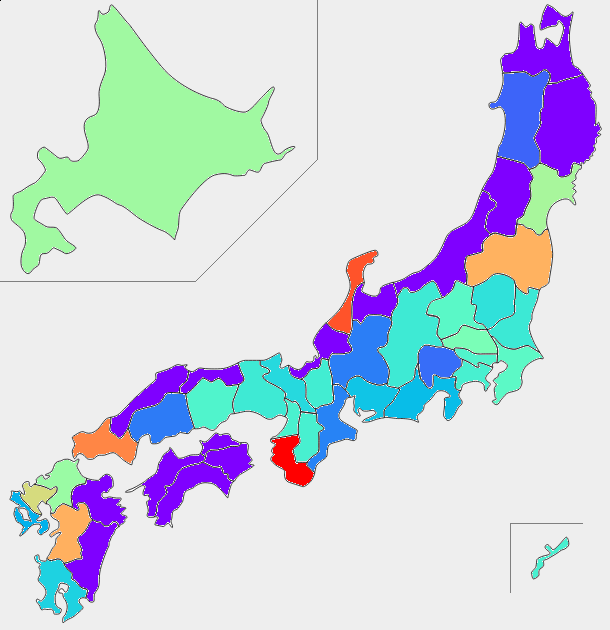

wrote to docs/images/japan-erns.jpg
wrote to docs/_includes/japan-erns.html


In [24]:
tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
make_japan_heatmap('japan-erns.jpg', tw_body_map_erns, latest_erns, populations)

In [25]:
#tw_body_map_erns = "全国 新型コロナ情報 都道府県別 実効再生産数"
#mak_japan_heatmap('docs/images/japan-erns.jpg', tw_body_map_erns, latest_erns, populations)


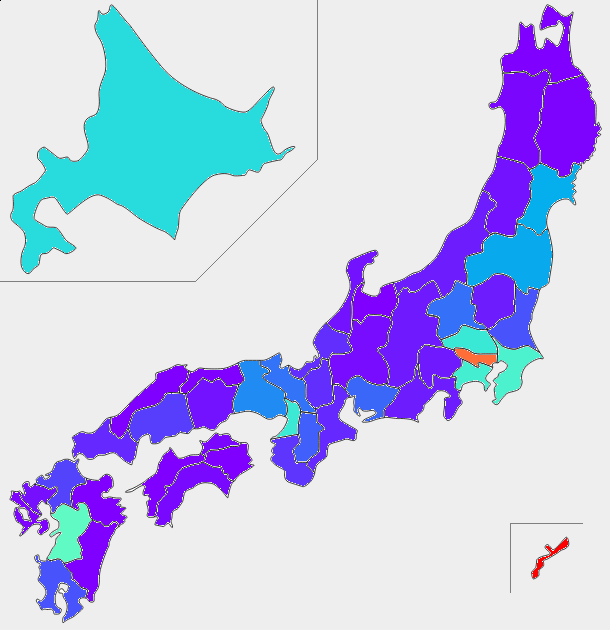

wrote to docs/images/japan-1w.jpg
wrote to docs/_includes/japan-1w.html


In [26]:
tw_body_map_1w = "全国 新型コロナ情報 都道府県別 直近1週間罹患率"
make_japan_heatmap('japan-1w.jpg', tw_body_map_1w, incid1w_rate, populations)


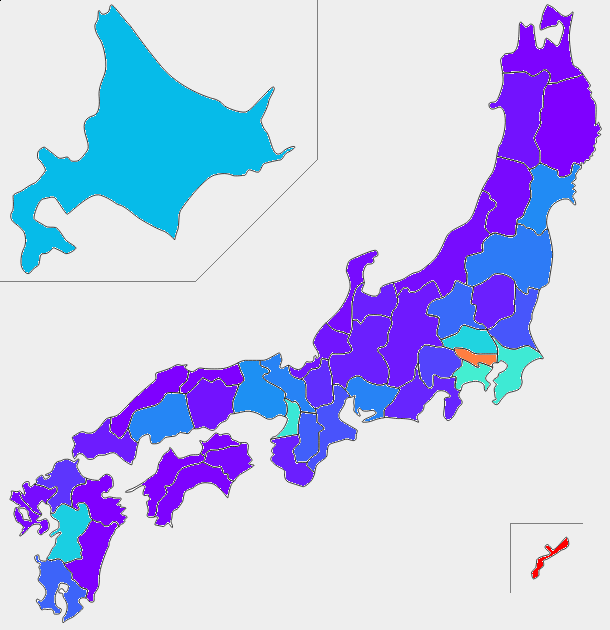

wrote to docs/images/japan-2w.jpg
wrote to docs/_includes/japan-2w.html


In [27]:
tw_body_map_2w = "全国 新型コロナ情報 都道府県別 直近2週間罹患率"
make_japan_heatmap('japan-2w.jpg', tw_body_map_2w, incid2w_rate, populations)


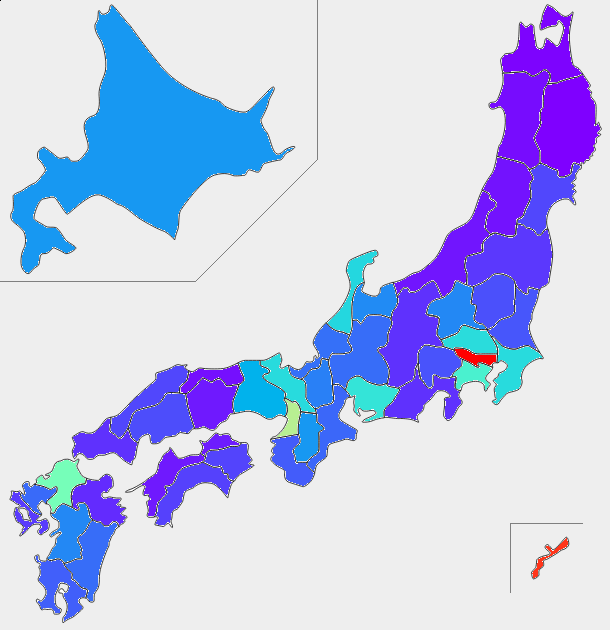

wrote to docs/images/japan-all.jpg
wrote to docs/_includes/japan-all.html


In [28]:
tw_body_map_all = "全国 新型コロナ情報 都道府県別 罹患率(全期間)"
make_japan_heatmap('japan-all.jpg', tw_body_map_all, incid_all_rate, populations)


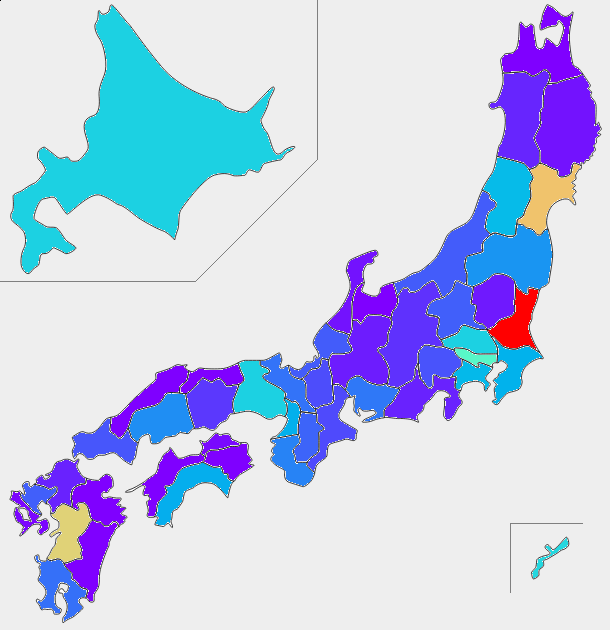

wrote to docs/images/japan-rate1w.jpg
wrote to docs/_includes/japan-rate1w.html


In [29]:
tw_body_map_rate1w = "全国 新型コロナ情報 都道府県別 直近1週間陽性率"
make_japan_heatmap('japan-rate1w.jpg', tw_body_map_rate1w, test1w_rate, populations)


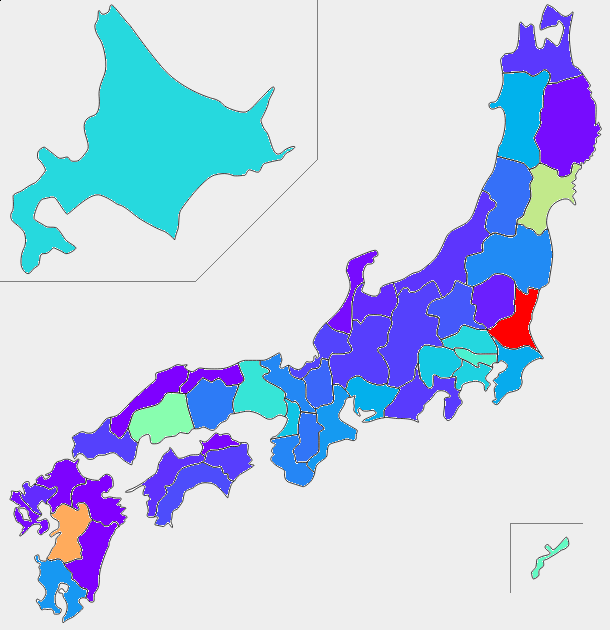

wrote to docs/images/japan-rate2w.jpg
wrote to docs/_includes/japan-rate2w.html


In [30]:
tw_body_map_rate2w = "全国 新型コロナ情報 都道府県別 直近2週間陽性率"
make_japan_heatmap('japan-rate2w.jpg', tw_body_map_rate2w, test2w_rate, populations)

In [31]:
tw = get_twitter()
today_str = dt.now().isoformat()[:19].replace('T', ' ')
tw_body_postfix = " https://geneasyura.github.io/cov19-hm/pref.html (東洋経済 " + today_str + " 現在)"
#tweet_with_image(tw, "images/ern-1w_poss.jpg", tw_body_1w + tw_body_postfix)
#tweet_with_image(tw, "images/ern-1w_poss-zoom.jpg", tw_body_1w_zoom + tw_body_postfix)
tweet_with_image(tw, "docs/images/ern-2w_poss.jpg", tw_body_2w + tw_body_postfix)
tweet_with_image(tw, "docs/images/ern-2w_poss-zoom.jpg", tw_body_2w_zoom + tw_body_postfix)

In [32]:
tweet_with_image(tw, 'docs/images/japan-erns.jpg', tw_body_map_erns + tw_body_postfix)
#tweet_with_image(tw, 'images/japan-1w.jpg', tw_body_map_1w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-2w.jpg', tw_body_map_2w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-all.jpg', tw_body_map_all + tw_body_postfix)

In [33]:
tweet_with_image(tw, 'docs/images/japan-rate1w.jpg', tw_body_map_rate1w + tw_body_postfix)
tweet_with_image(tw, 'docs/images/japan-rate2w.jpg', tw_body_map_rate2w + tw_body_postfix)